# Support identification: TSOC vs GR

Compressed Sensing (CS) is based on the hypothesis that the input is sparse in some domain, where with sparse we mean a signals whose components are mostly null and only a small minority is different from zero. However, real-world signals are hardly ever sparse due to different reasons as for example the presence of noise in acquisition. Hence, signals cannot be considered sparse but **compressible**, i.e., most components are negligible compared with a small minority which have a significantly higher magnitude.

In the literature, there exist a family of CS decoders [[1]](#TBCAS2020) which reconstruct the input from the mesurement by leveraging the knowledge of the **support** which indicates the position of the non-null coefficients in the sparse representation of the input. 

However, we can define a signal support only when the signal is sparse. In [[2]](#JETCAS2020), we extended the definition of support to compressible signals as the support that, given a CS encoder, maximizes the quality of reconstruction. This definition of support for compressible signals has the disadvantage to depend on how the signal is compressed into measurements, i.e., it depends on the CS encoder.

Recently, we explored the possibility to define a support of a compressible signal independetly from encoding. The idea consists in considering the components with highest magnitude that retain a certain fraction of energy $\eta$. We call this method GR (intials of Gabriele Ravaglia, the student who worked on this first)

This notebook aims to compare the TSOC method (the one proposed in [[2]](#JETCAS2020)) to the recently considered GR method. We expect the former to outperform the latter but depending on the differences there may be cases in which the GR method is preferrable.


In [1]:
%matplotlib widget

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

In [3]:
import os
import sys

import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import neurokit2 as nk

import multiprocessing as mp

from itertools import product

from scipy import linalg
from numpy import random

from tqdm import tqdm


In [22]:
# import of local modules
root = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
sys.path.insert(0, os.path.join(root, 'src'))

from dataset.synthetic_ecg import generate_ecg
from cs.wavelet_basis import wavelet_basis
from cs import CompressedSensing, generate_sensing_matrix
from cs.supports import find_support_GR, find_support_TSOC, find_support_TSOC2
from cs.utils import compute_rsnr

## Dataset

We use a synthetic Electrocardiography (ECG) dataset, the same employed in [[1]](#TBCAS2020) and [[2]](#JETCAS2020). The dataset has been generated with [ECGSYN](https://physionet.org/content/ecgsyn/1.0.0/) (which implements the algorithm reported in [[3]](#McSharry_TBME2003)).

The heart-beat rate is randomly set using an uniform distribution between 60 and 100 beat/minute. We generate chunks of 2s with a 256sample/s sampling frequency, that are split into windows
of n subsequent samples.

In [5]:
# path to store data such as generated ECG, supports and RSNR values
data_folder = '/srv/newpenny/dnn-cs/tsoc/data/'
if not os.path.exists(data_folder):
    os.mkdir(data_folder)

In [6]:
N = 10_000              # number of ECG traces
n = 128                 # length of an ECG trace
fs = 256                # sampling rate
heart_rate = (60, 100)  # min and max heart rate
isnr = 45               # signal-to-noise ratio in dB (35)
ecg_seed = 0            # random seed for ECG generation
processes = 24          # number of processes for multiprocessing

data_name = f'ecg_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
            f'_isnr={isnr}_seed={ecg_seed}'
data_path = os.path.join(data_folder, data_name + '.pkl')
if os.path.exists(data_path):
    with open(data_path, 'rb') as f:
        X = pickle.load(f)
else:
    X = generate_ecg(
        length=n, 
        num_traces=N,
        heart_rate=heart_rate, 
        sampling_rate=fs, 
        snr=isnr, 
        random_state=ecg_seed,
        verbose=True,
        processes=processes,
    )
    with open(data_path, 'wb') as f:
        pickle.dump(X, f)

folder = os.path.join(data_folder, data_name)
if not os.path.exists(folder):
    os.mkdir(folder)

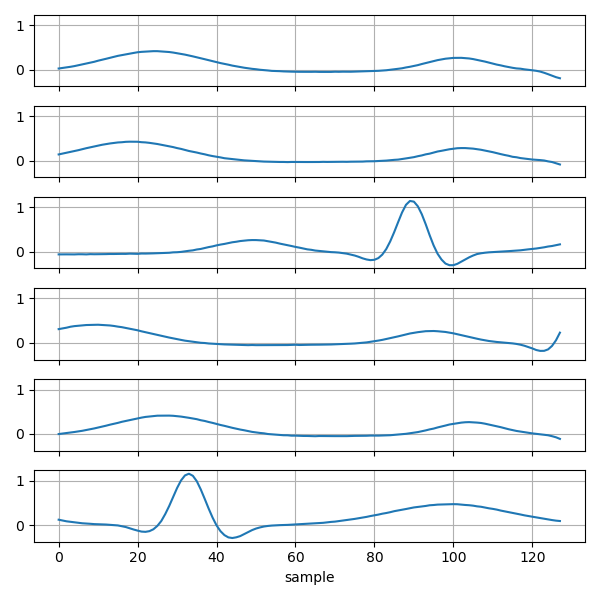

In [7]:
num_plot = 6

fig, axs = plt.subplots(num_plot, 1, figsize=(6, 1.*num_plot), 
                        sharex='all', sharey='all')
for i, (ax, x) in enumerate(zip(axs, X)):
    ax.plot(x)
    ax.grid()
axs[-1].set(xlabel='sample')
fig.tight_layout()

As in [[1]](#TBCAS2020) and [[2]](#JETCAS2020) and firstly proposed in [[4]](#TBCAS2015), we employ the Symmlet-6 family of the orthogonal Wavelet functions as a Sparsity basis.

In [8]:
basis = 'sym6'

D = wavelet_basis(n, basis, level=2)

## GR Algorithm

Identify signal support with GR algortithm which identify the support by considering the smallest subsets of compontest that retains a given energy fraction.

### Experiments

The experiments measure the Resconstruction Signal to Ratio (RSNR) in different settings. Different settings involve:
- data: the amount of noise injected into the synthetic ECG signal
- support identification method: the amount of energy fraction used to determine the support
- compressed sensing system: the amount of measurements (`m`), the type of encoder (standard or rakeness-based), and whether the sensing matrix is orthogonalized or not.

In [10]:
# Experiment parameters

# ---- data ----
isnr_list = (25, 35, 45)  # Intrinsic Signal-to-Noise Ratio

# ---- support ---- 
method = 'GR' # support identification algorithm
eta_list = (
    0.9, 
    0.93,    0.95,    0.97,    0.98,    0.985,    0.99, 
    0.993,   0.995,   0.997,   0.998,   0.9985,   0.999, 
    0.9993,  0.9995,  0.9997,  0.9998,  0.99985,  0.9999, 
    0.99993, 0.99995, 0.99997, 0.99998, 0.999985, 0.99999,
)  # energy fractions

# ---- compressed sensing ---- 
m_list = (16, 32, 48, 64)  # number of measurements
mode = 'standard'  # CS mode: standard, rakeness
orth = True  # whether orthogonalize sensing matrix or not

The experiments are conducted through the script `compute_rsnr_GR.py`. Here we load and visulize the results.

In [11]:
rsnr = []
for isnr in isnr_list:
    data_name = f'ecg_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
                f'_isnr={isnr}_seed={ecg_seed}'
    folder = os.path.join(data_folder, data_name)
    rsnr_path = os.path.join(folder, f'rsnr_method={method}.pkl')
    tmp = pd.read_pickle(rsnr_path)
    tmp = tmp.xs((mode, orth), level=('mode', 'orth'), axis=1)
    tmp = tmp.reindex(columns=eta_list, level='eta')
    tmp = tmp.reindex(columns=m_list, level='m')
    tmp = pd.concat(
        [tmp], axis=1, keys=[isnr], names=['isnr'] + tmp.columns.names)
    rsnr.append(tmp)
rsnr = pd.concat(rsnr, axis=1)
rsnr

isnr         25                                                         \
m            16                                                          
seed         0                                                           
eta    0.900000   0.930000   0.950000   0.970000   0.980000   0.985000   
0      9.612902  10.962917  13.449371  14.840563  13.363046  13.132825   
1     10.049288  11.685948  12.591843  12.853327  15.898936  15.322616   
2      9.196780  10.583342   9.684623  12.299782  13.711138  11.179897   
3     11.421167  11.421167  12.901961  14.606385  15.452560  11.809157   
4     10.787403  10.787403  13.247910  13.247910  16.024613  16.024613   
...         ...        ...        ...        ...        ...        ...   
9995   9.893702   9.372370  10.412854  11.521624   7.711004  11.708563   
9996   9.773491  11.419555  11.827468  12.924842  11.065241  11.718313   
9997   9.757627   8.708279  10.053165  12.749027  10.842691   9.893957   
9998   8.723471  10.119044   7.661431   8.049084   9.941032   8.317867   
9999   9.282162  10.702381  10.631111  11.761859  15.218968  12.665206   

isnr                                             ...         45             \
m                                                ...         64              
seed                                             ...         19              
eta    0.990000   0.993000   0.995000  0.997000  ...   0.999700   0.999800   
0      9.517469 -32.851756   6.166356  2.749540  ...  35.061583  36.047504   
1     14.501457  14.929238  -2.114650  3.247804  ...  34.906515  36.530780   
2      7.404768   6.997907   7.021819  5.963204  ...  34.069877  35.558708   
3     11.063365   3.994907   2.673009  1.826635  ...  34.235136  36.839376   
4     19.105950  14.446767   9.726785  2.662777  ...  34.667146  35.990713   
...         ...        ...        ...       ...  ...        ...        ...   
9995   7.989766   8.560071   3.824292  3.614427  ...  33.970628  34.865499   
9996   9.591930   9.205926   4.118411  2.236221  ...  33.899599  36.172167   
9997  10.109721   5.092679   5.407157  3.510387  ...  34.376090  35.687120   
9998   5.595880   4.324418   3.156709  1.917451  ...  34.710938  35.509196   
9999  12.875190  16.540115  12.461110  7.767568  ...  34.910716  36.897693   

isnr                                                                    \
m                                                                        
seed                                                                     
eta    0.999850   0.999900   0.999930   0.999950   0.999970   0.999980   
0     37.423549  38.906114  40.902782  40.966648  42.575459  43.897881   
1     37.066584  38.734545  40.140351  41.512612  42.984899  40.756129   
2     37.249507  39.107745  40.321096  40.838465  42.639867  42.680097   
3     38.151248  38.908650  39.659300  40.751262  42.171856  42.120187   
4     37.439587  38.758942  40.331442  41.213662  41.217525  41.862158   
...         ...        ...        ...        ...        ...        ...   
9995  35.410568  36.772671  38.727995  39.758097  42.219679  43.231912   
9996  36.172167  38.198824  39.168063  39.903219  41.883864  43.056738   
9997  36.482656  37.104638  37.889552  39.445834  40.809242  42.911092   
9998  36.323118  38.192803  37.535673  36.590130  34.769696   9.531880   
9999  37.730673  38.692728  41.069064  41.853642  43.601227  44.671739   

isnr                        
m                           
seed                        
eta    0.999985   0.999990  
0     40.321750  28.131486  
1     41.713337  40.358146  
2     42.600849  29.057066  
3     40.798967  41.284004  
4     40.342642  34.810184  
...         ...        ...  
9995  42.472381  42.123074  
9996  39.978130  26.835686  
9997  42.465984  40.813524  
9998   8.447427   7.225033  
9999  44.929064  42.961759  

[10000 rows x 4871 columns]

In [12]:
# compute statistics
_rsnr = rsnr.stack('seed')
rsnr_med = _rsnr.median().unstack(('isnr', 'm'))
rsnr_q25 = _rsnr.quantile(.25).unstack(('isnr', 'm'))
rsnr_q75 = _rsnr.quantile(.75).unstack(('isnr', 'm'))
eta_best = rsnr_med.idxmax()

isnr,25,35,45
m,,,
16,12.594393,13.641275,13.947969
32,19.916347,26.269935,30.249917
48,23.300175,31.230582,38.601504
64,25.674729,34.407211,42.816118


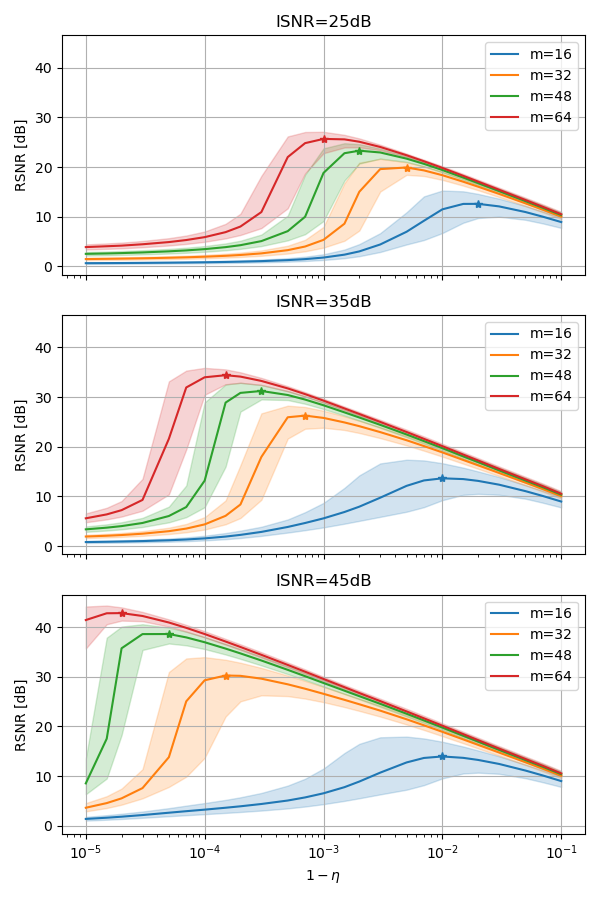

In [13]:
ncols = min(int(np.floor(np.sqrt(len(isnr_list)))), 4)
nrows = len(isnr_list) // ncols

fig, axs = plt.subplots(nrows, ncols, figsize=(6, 3*nrows), 
                        sharex='all', sharey='all', squeeze=False)
index = 1 - rsnr_med.index

for ax, isnr in zip(axs.flatten(), isnr_list):
    for i, m in enumerate(rsnr_med[isnr].columns):
        ax.plot(index, rsnr_med[isnr, m], label=f'm={m}')
        ax.fill_between(index, rsnr_q25[isnr, m], rsnr_q75[isnr, m], 
                        color=f'C{i}', alpha=0.2)
        ax.plot([1 - eta_best[isnr, m]], [rsnr_med.max()[isnr, m]], 
                marker='*', color=f'C{i}')
    ax.set(xscale='log')
    ax.set(title=f'ISNR={isnr}dB')
    ax.grid()
    ax.legend()
for ax in axs[:, 0]: ax.set(ylabel='RSNR [dB]')
for ax in axs[-1]: ax.set(xlabel='$1-\eta$')

fig.tight_layout()
rsnr_med.max().unstack('isnr')


- the higher the number of mesurements `m` (i.e., lower the compression ratio) the higher the energy fraction $\eta$ that gives the best performance. This is intuitive as a higher compression leaves less room for components.

- As the noise energy increases (lower ISNR), the lower the the energy fraction $\eta$ that gives the best performance. This behavior is expected as with a higher noise swallows more components so that a fewer number contributes for the signal reconstruction.


## TSOC Algorithm

Identify signal support with TSOC algortithm which identify the support as the one maximizing the quality of reconstruction.

### working principle

TSOC algorithm is a greedy algorithm that finds a proxy of the support that maximizes the RSNR. 

The algorithm is iterative and builds the support considering one component at a time ordered from the highest to lowest magnitude up to the `m`-th components, where `m` is the number of measurements (i.e., the dimension of the compressed signal `y`). At each iteration, the algorithms includes a new component, reconstructs the input signal, and measures the quality in terms of RSNR. 

Following the iterative procedure, the algorithm selects the support as the one that gave the highest RSNR.

Here, we show how TSOC algorithm finds the support `s` of a signal `x` for different values of `m` (number of measurements) and sensing matrices `A` generated with different seeds.

In [15]:
i_sample = 0  # index of the ECG sample
m_list = (8, 16, 32, 48, 64)
seed_list = np.arange(100)

# load ecg data
with open(data_path, 'rb') as f:
    X = pickle.load(f)
x = X[i_sample]

rsnr = pd.DataFrame(
    index=1 + np.arange(max(m_list)),
    columns=pd.MultiIndex.from_product(
        (m_list, seed_list), names=('m', 'seed')),
    dtype=float,
)
for seed in tqdm(seed_list):

    A = generate_sensing_matrix((np.max(m_list), n), seed=seed)

    for m in m_list:
        # find and sort sparse representation of x
        xi = D.T @ x
        argsort_xi = np.argsort(np.abs(xi))[::-1]
        
        # compute measurements
        cs = CompressedSensing(A[:m], D)
        y = cs.encode(x)

        # apply algorithm
        s = np.zeros(cs.n, dtype=bool)
        for i in range(m + 10):
            s[argsort_xi[i]] = True  # update support
            x_hat = cs.decode(y, s=s)  # reconstruct input
            rsnr.loc[i + 1, (m, seed)] = compute_rsnr(x, x_hat)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:26<00:00,  3.79it/s]


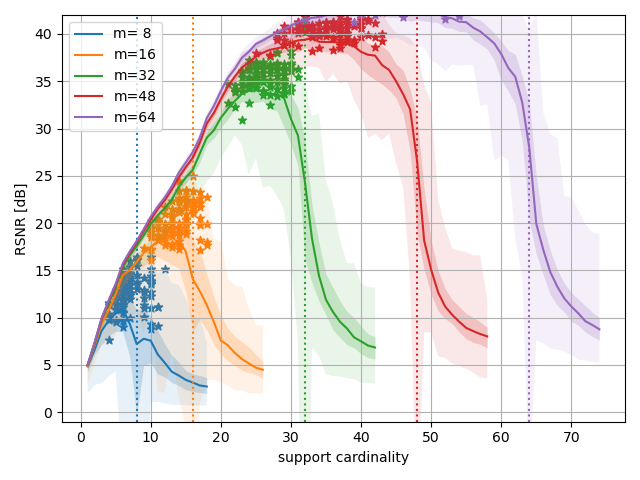

In [16]:
fig, ax = plt.subplots()
for i, m in enumerate(m_list):
    color = f'C{i}'
    _rsnr = rsnr.xs(m, level='m', axis=1).dropna().T
    ax.plot(_rsnr.median(), label=f'm={m:2d}', color=color)
    ax.fill_between(_rsnr.columns, _rsnr.quantile(.25), _rsnr.quantile(.75), 
                    alpha=0.2, color=color, lw=0)
    ax.fill_between(_rsnr.columns, _rsnr.min(), _rsnr.max(), 
                    alpha=0.1, color=color, lw=0)
    ax.scatter(_rsnr.idxmax(axis=1), _rsnr.max(axis=1), c=color, marker='*')
    ax.axvline(m, color=color, ls=':')
ax.set(xlabel='support cardinality', ylabel='RSNR [dB]', ylim=(-1, 42))
ax.grid()
ax.legend()
fig.tight_layout()

### Experiments

The experiments measure the Resconstruction Signal to Ratio (RSNR) in different settings. Different settings involve:
- data: the amount of noise injected into the synthetic ECG signal
- compressed sensing system: the amount of measurements (`m`), the type of encoder (standard or rakeness-based), and whether the sensing matrix is orthogonalized or not.

In [27]:
# Experiment parameters

# ---- data ----
isnr_list = (25, 35, 45)  # Intrinsic Signal-to-Noise Ratio

# ---- support ----
method = 'TSOC'  # support identification algorithm

# ---- compressed sensing ----
m_list = (16, 32, 48, 64)  # number of measurements
# mode = 'standard'  # CS mode: standard, rakeness
mode_list = ('standard', 'rakeness')  # CS mode: standard, rakeness
orth = True  # whether orthogonalize sensing matrix or not

# ---- rakeness ----
loc = .25
corr_name = '96af96a7ddfcb2f6059092c250e18f2a'



The experiments are conducted through the script `compute_rsnr_TSOC.py`. Here we load and visulize the results.

In [28]:
rsnr = []
for isnr in isnr_list:
    data_name = f'ecg_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
                f'_isnr={isnr}_seed={ecg_seed}'
    folder = os.path.join(data_folder, data_name)
    rsnr_path = os.path.join(folder, f'rsnr_method={method}.pkl')
    tmp = pd.read_pickle(rsnr_path)
    # tmp = tmp.xs((mode, orth), level=('mode', 'orth'), axis=1)
    tmp = tmp.xs(orth, level='orth', axis=1)
    tmp = tmp.reindex(columns=mode_list, level='mode')
    tmp = tmp.reindex(columns=m_list, level='m')
    tmp = pd.concat(
        [tmp], axis=1, keys=[isnr], names=['isnr'] + tmp.columns.names)
    rsnr.append(tmp)
rsnr = pd.concat(rsnr, axis=1)

# rsnr.count().unstack(('isnr', 'm'))

In [48]:
_rsnr = rsnr.stack('seed')
rsnr_med = _rsnr.median()

rsnr_med.unstack(('isnr', 'mode'))

isnr         25                    35                    45           
mode   rakeness   standard   rakeness   standard   rakeness   standard
m                                                                     
16    15.571108  14.487343  16.574684  15.892789  16.622824  16.084519
32    22.753675  21.328009  29.682694  28.031608  34.084793  32.487712
48    25.384903  24.291980  33.719108  32.522725  41.583933  40.298295
64    27.508285  26.720979  36.343827  35.476445  44.942091  44.013530

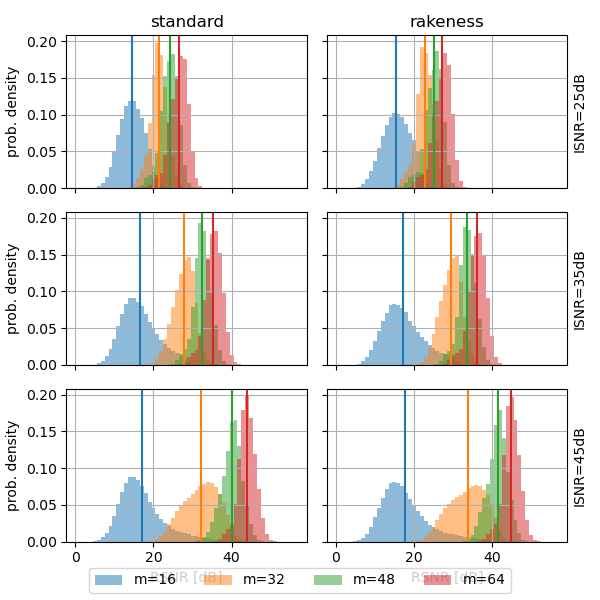

In [47]:
ncols, nrows = len(mode_list), len(isnr_list)
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 2*nrows), 
                        sharex='all', sharey='all', squeeze=False)
ebin_width = 1.
ebin_min = np.round(np.min(rsnr.values)) - ebin_width/2
ebin_max = np.round(np.max(rsnr.values)) + ebin_width/2
ebins = np.arange(ebin_min, ebin_max, ebin_width)
for _axs, isnr in zip(axs, isnr_list):
    for ax, mode in zip(_axs, mode_list):
        __rsnr = _rsnr.xs((isnr, mode), level=('isnr','mode'), axis=1)
        for i, m in enumerate(__rsnr.columns.unique('m')):
            color = f'C{i}'
            ax.hist(__rsnr[m], bins=ebins, density=True, 
                    alpha=0.5, label=f'm={m}', color=color)
            ax.axvline(__rsnr[m].mean(), color=color)
            # ax.axvline(__rsnr[m].median(), color=color)
        ax.grid(True)
    _axs[0].set(ylabel='prob. density')


for ax, mode in zip(axs[0], mode_list): ax.set(title=mode)
for ax, isnr in zip(axs[:, -1], isnr_list): 
    ax.text(1.05, 0.5, f'ISNR={isnr}dB', rotation='vertical', 
            va='center', ha='center', transform=ax.transAxes)
for ax in axs[-1]: ax.set(xlabel='RSNR [dB]')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=max(4, len(m_list)))
fig.tight_layout()


## TSOC2 Algorithm

### working principle


**TOFIX**

TSOC algorithm is a greedy algorithm that finds a proxy of the support that maximizes the RSNR. 

The algorithm is iterative and builds the support considering one component at a time ordered from the highest to lowest magnitude up to the `m`-th components, where `m` is the number of measurements (i.e., the dimension of the compressed signal `y`). At each iteration, the algorithms includes a new component, reconstructs the input signal, and measures the quality in terms of RSNR. 

Following the iterative procedure, the algorithm selects the support as the one that gave the highest RSNR.

Here, we show how TSOC algorithm finds the support `s` of a signal `x` for different values of `m` (number of measurements) and sensing matrices `A` generated with different seeds.

In [21]:
i_sample = 0  # index of the ECG sample
m_list = (8, 16, 32, 48, 64)
seed_list = np.arange(20)
delta_m = 10

# load ecg data
with open(data_path, 'rb') as f:
    X = pickle.load(f)
x = X[i_sample]

rsnr = pd.DataFrame(
    index=1 + np.arange(max(m_list) + delta_m),
    columns=pd.MultiIndex.from_product(
        (m_list, seed_list), names=('m', 'seed')),
    dtype=float,
)
for seed in tqdm(seed_list):

    A = generate_sensing_matrix((np.max(m_list), n), seed=seed)

    for m in m_list:        
        # compute measurements
        cs = CompressedSensing(A[:m], D)
        y = cs.encode(x)

        # apply algorithm
        _m = min(cs.n, cs.m + delta_m)
        s1 = np.zeros(cs.n, dtype=bool) 
        for i in range(_m):
            rsnr2 = -np.inf * np.ones(cs.n, dtype=float)
            for j in np.where(~s1)[0]:  
                s2 = s1.copy()
                s2[j] = True
                x_hat = cs.decode_with_support(y, s2)
                rsnr2[j] = compute_rsnr(x, x_hat)
            s_idx = np.argmax(rsnr2)
            s1[s_idx] = True
            rsnr.loc[i + 1, (m, seed)] = rsnr2[s_idx]
            # print(rsnr.loc[i + 1, (m, seed)])

  0%|          | 0/20 [00:03<?, ?it/s]


KeyboardInterrupt: 


KeyboardInterrupt



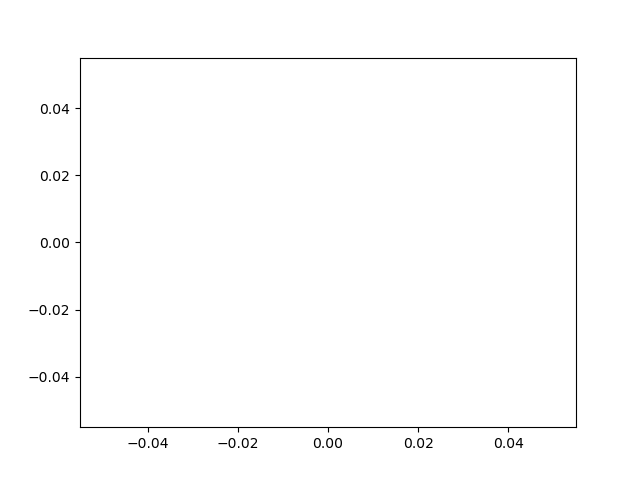

In [22]:
fig, ax = plt.subplots()
for i, m in enumerate(m_list):
    color = f'C{i}'
    _rsnr = rsnr.xs(m, level='m', axis=1).dropna().T
    ax.plot(_rsnr.median(), label=f'm={m:2d}', color=color)
    ax.fill_between(_rsnr.columns, _rsnr.quantile(.25), _rsnr.quantile(.75), 
                    alpha=0.2, color=color, lw=0)
    ax.fill_between(_rsnr.columns, _rsnr.min(), _rsnr.max(), 
                    alpha=0.1, color=color, lw=0)
    ax.scatter(_rsnr.idxmax(axis=1), _rsnr.max(axis=1), c=color, marker='*')
    ax.axvline(m, color=color, ls=':')
ax.set(xlabel='support cardinality', ylabel='RSNR [dB]')
ax.grid()
ax.legend()
fig.tight_layout()

### Experiments

The experiments measure the Resconstruction Signal to Ratio (RSNR) in different settings. Different settings involve:
- data: the amount of noise injected into the synthetic ECG signal
- compressed sensing system: the amount of measurements (`m`), the type of encoder (standard or rakeness-based), and whether the sensing matrix is orthogonalized or not.

In [10]:
# Experiment parameters

# ---- data ----
isnr_list = (35, )  # Intrinsic Signal-to-Noise Ratio

# ---- support ----
method = 'TSOC2'  # support identification algorithm

# ---- compressed sensing ----
m_list = (16, 32, 48, 64)  # number of measurements
mode = 'standard'  # CS mode: standard, rakeness
orth = True  # whether orthogonalize sensing matrix or not


The experiments are conducted through the script `compute_rsnr_TSOC.py`. Here we load and visulize the results.

In [11]:
rsnr = []
for isnr in isnr_list:
    data_name = f'ecg_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
                f'_isnr={isnr}_seed={ecg_seed}'
    folder = os.path.join(data_folder, data_name)
    rsnr_path = os.path.join(folder, f'rsnr_method={method}.pkl')
    tmp = pd.read_pickle(rsnr_path)
    # tmp = tmp.loc[:,~tmp.columns.duplicated()].copy()
    tmp = tmp.xs((mode, orth), level=('mode', 'orth'), axis=1)
    tmp = tmp.reindex(columns=m_list, level='m')
    tmp = pd.concat(
        [tmp], axis=1, keys=[isnr], names=['isnr'] + tmp.columns.names)
    rsnr.append(tmp)
rsnr = pd.concat(rsnr, axis=1)

In [12]:
rsnr.count().unstack(('isnr', 'm'))

isnr       35                           
m          16       32       48       64
seed                                    
0     10000.0  10000.0  10000.0   9999.0
1     10000.0  10000.0  10000.0  10000.0
2     10000.0  10000.0  10000.0  10000.0
3     10000.0  10000.0  10000.0  10000.0
4     10000.0  10000.0  10000.0  10000.0
5     10000.0  10000.0  10000.0  10000.0
6     10000.0  10000.0  10000.0  10000.0
7     10000.0  10000.0  10000.0   9999.0
8     10000.0  10000.0  10000.0  10000.0
9     10000.0  10000.0  10000.0  10000.0
10    10000.0  10000.0  10000.0  10000.0
11    10000.0  10000.0  10000.0  10000.0
12    10000.0  10000.0  10000.0      NaN
13    10000.0  10000.0  10000.0      NaN
14    10000.0  10000.0  10000.0      NaN
15    10000.0  10000.0  10000.0      NaN
16    10000.0  10000.0  10000.0      NaN
17    10000.0  10000.0  10000.0      NaN
18    10000.0  10000.0  10000.0      NaN
19    10000.0  10000.0  10000.0      NaN

In [31]:
_rsnr = rsnr.stack('seed')
rsnr_med = _rsnr.median()
rsnr_q25 = _rsnr.quantile(.25)
rsnr_q75 = _rsnr.quantile(.75)

rsnr_med.unstack('isnr')

isnr,35
m,
16,14.983202
32,27.435815
48,33.229439
64,36.343427


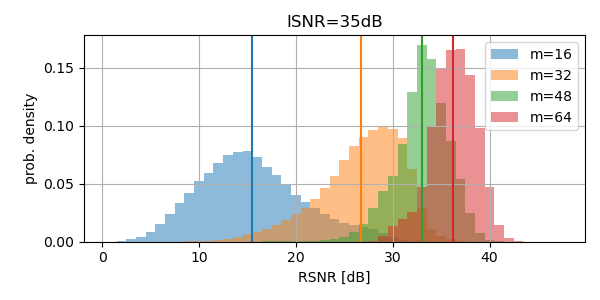

In [32]:
ncols = min(int(np.sqrt(np.floor(len(isnr_list)))), 4)
nrows = len(isnr_list) // ncols

fig, axs = plt.subplots(nrows, ncols, figsize=(6, 3*nrows), 
                        sharex='all', sharey='all', squeeze=False)
ebin_width = 1.
ebin_min = np.round(np.nanmin(rsnr.values)) - ebin_width/2
ebin_max = np.round(np.nanmax(rsnr.values)) + ebin_width/2
ebins = np.arange(ebin_min, ebin_max, ebin_width)
for ax, isnr in zip(axs.flatten(), isnr_list):
    __rsnr = _rsnr.xs(isnr, level='isnr', axis=1)
    for i, m in enumerate(__rsnr.columns.unique('m')):
        color = f'C{i}'
        ax.hist(__rsnr[m], bins=ebins, density=True, 
                alpha=0.5, label=f'm={m}', color=color)
        ax.axvline(__rsnr[m].mean(), color=color)
        # ax.axvline(__rsnr[m].median(), color=color)
    ax.set(title=f'ISNR={isnr}dB')
    ax.grid()
    ax.legend()
for ax in axs[:, 0]: ax.set(ylabel='prob. density')
for ax in axs[-1]: ax.set(xlabel='RSNR [dB]')

fig.tight_layout()


## References


1. <a name="TBCAS2020"></a> M. Mangia, L. Prono, A. Marchioni, F. Pareschi, R. Rovatti and G. Setti, "Deep Neural Oracles for Short-Window Optimized Compressed Sensing of Biosignals," in IEEE Transactions on Biomedical Circuits and Systems, vol. 14, no. 3, pp. 545-557, June 2020, doi: [10.1109/TBCAS.2020.2982824](www.doi.org/10.1109/TBCAS.2020.2982824)
2. <a name="JETCAS2020"></a> L. Prono, M. Mangia, A. Marchioni, F. Pareschi, R. Rovatti and G. Setti, "Deep Neural Oracle With Support Identification in the Compressed Domain," in IEEE Journal on Emerging and Selected Topics in Circuits and Systems, vol. 10, no. 4, pp. 458-468, Dec. 2020, doi: [10.1109/JETCAS.2020.3039731](www.doi.org/10.1109/JETCAS.2020.3039731)
3. <a name="McSharry_TBME2003"></a> P. E. McSharry, G. D. Clifford, L. Tarassenko and L. A. Smith, "A dynamical model for generating synthetic electrocardiogram signals," in IEEE Transactions on Biomedical Engineering, vol. 50, no. 3, pp. 289-294, March 2003, doi: [10.1109/TBME.2003.808805](www.doi.org/10.1109/TBME.2003.808805)
4. <a name="TBCAS2015"></a> F. Pareschi, P. Albertini, G. Frattini, M. Mangia, R. Rovatti and G. Setti, "Hardware-Algorithms Co-Design and Implementation of an Analog-to-Information Converter for Biosignals Based on Compressed Sensing," in IEEE Transactions on Biomedical Circuits and Systems, vol. 10, no. 1, pp. 149-162, Feb. 2016, doi: [10.1109/TBCAS.2015.2444276](www.doi.org/10.1109/TBCAS.2015.2444276)